In [1]:
import psycopg2
import pandas as pd
import matplotlib
%matplotlib inline

In [2]:
conn = psycopg2.connect(dbname="postgres", user="postgres", password="postgres", host="postgres")

In [3]:
cur = conn.cursor()

# Database structure

![Database structure](images/database-structure.png)

*aisles*, *departments* and *products* tables are self-explainatory.

*order_products* table has two interesting fields:
* *add_to_cart_order* shows order in which items were added to order;
* *reordered* shows whether user has ordered the product before.

*orders* table's fields:
* *user_id* is user identifier;
* *eval_set* shows to which evaluation set order belongs. This will probably not be used for analysis purposes;
* *order_number* describes sequence of orders that user has put;
* *day_of_week* tells day of the week that order was placed on;
* *hour_of_day* tells hour that order was placed on;
* *days_since_prior_order* gives number of days since the last user's order. It is capped at 30.

This was extracted from https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

### How many products each aisle has?

In [4]:
cur.execute("SELECT a.name, COUNT(p.id) FROM aisles AS a JOIN products AS p on p.aisle_id = a.id GROUP BY a.id")
aisles_with_product_count = pd.DataFrame(cur.fetchall())
aisles_with_product_count.columns = ["name", "products"]
aisles_with_product_count.head(5)

,name,products
0,more household,308
1,frozen produce,361
2,refrigerated pudding desserts,98
3,bulk grains rice dried goods,26
4,preserved dips spreads,264


In [5]:
aisles_with_product_count["products"].describe()

count     134.000000
mean      370.805970
std       267.010165
min        12.000000
25%       179.750000
50%       305.500000
75%       497.500000
max      1258.000000
Name: products, dtype: float64

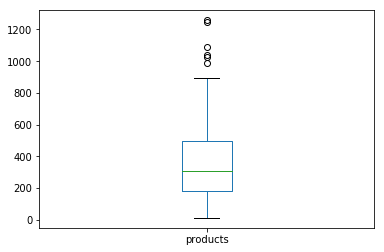

In [6]:
aisles_with_product_count.plot(kind="box")

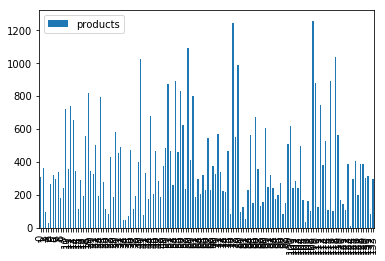

In [7]:
aisles_with_product_count.plot(kind="bar")

Most of the aisles have between about 179 and 497 products. It has some outliers. Although I can't see how that could be useful yet.

### How many products each department has?

In [8]:
cur.execute("SELECT d.name, COUNT(p.id) FROM departments AS d JOIN products AS p on p.department_id = d.id GROUP BY d.id")
departments_with_product_count = pd.DataFrame(cur.fetchall())
departments_with_product_count.columns = ["name", "products"]
departments_with_product_count.head(5)

,name,products
0,snacks,6264
1,produce,1684
2,bulk,38
3,international,1139
4,pantry,5371


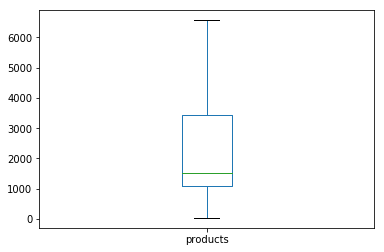

In [9]:
departments_with_product_count["products"].plot(kind="box")

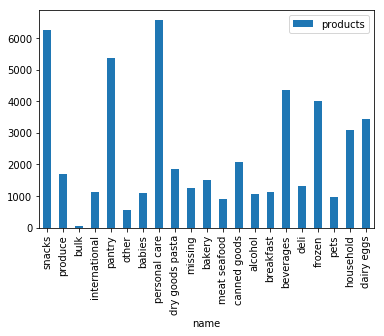

In [10]:
departments_with_product_count.plot(kind="bar", x="name")

It looks like biggest assortiment is consumables (foods and drinks).

### How many orders there are?

In [11]:
cur.execute("SELECT COUNT(*) FROM orders")
cur.fetchone()

(3421083,)

### How many orders each user has made?

In [12]:
cur.execute("SELECT o.user_id, COUNT(o.id) FROM orders AS o GROUP BY o.user_id")
users_with_order_count = pd.DataFrame(cur.fetchall())
users_with_order_count.columns = ["user", "orders"]
users_with_order_count.head(5)

,user,orders
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [13]:
users_with_order_count["orders"].describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: orders, dtype: float64

In [14]:
users_with_order_count["orders"].mode()

0    4
dtype: int64

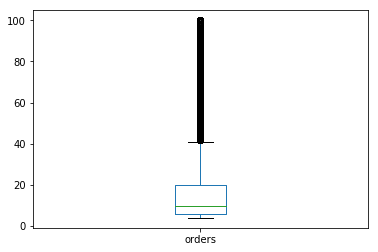

In [15]:
users_with_order_count["orders"].plot(kind="box")

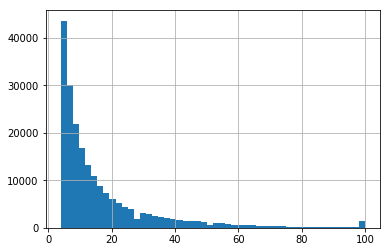

In [16]:
users_with_order_count["orders"].hist(bins=50)

In [17]:
q1 = users_with_order_count["orders"].quantile(0.25)
q3 = users_with_order_count["orders"].quantile(0.75)
iqr = q3 - q1
outliers = users_with_order_count[users_with_order_count["orders"] > q3+1.5*iqr]
print(len(outliers)/len(users_with_order_count))

0.08252307125295211


This is also looks like logarithmic distribution. What we can see is that most users make 4 orders. I believe good central measurement would be median. 8% of the users buy unusually much. These may not represent statistical user, so they may be cleaned in further analysis.

### How much time does it take for user to place next order?

In [18]:
cur.execute("SELECT days_since_prior_order FROM orders")
days_since_prior_order = pd.DataFrame(cur.fetchall())
days_since_prior_order.columns = ["days"]
days_since_prior_order.head()

,days
0,4.0
1,3.0
2,30.0
3,7.0
4,6.0


In [19]:
# percentage of NaN values
days_since_prior_order["days"].isnull().sum()/len(days_since_prior_order)

0.06027594185817766

Clearing those NaN values

In [20]:
days_since_prior_order = days_since_prior_order[~days_since_prior_order["days"].isnull()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a05422ba8>]], dtype=object)

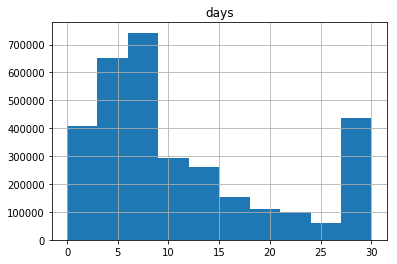

In [21]:
days_since_prior_order.hist()

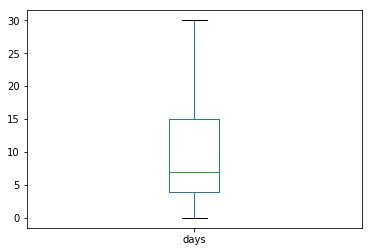

In [22]:
days_since_prior_order.plot(kind="box")

It seems pretty clean. Histogram kinda reminds Poisson distribution except for the end. In further analysis, we may ignore that and assume Poisson distribution.

It looks like most of the recurring orders occur in around first week.

### How many items people buy in a single order?

Does the each *order_products* row means one item added to cart?

In [23]:
cur.execute("SELECT COUNT(op.product_id) FROM order_products as OP GROUP BY op.order_id HAVING COUNT(op.product_id) > 1")
len(cur.fetchall()) > 0

True

In [24]:
cur.execute("SELECT o.id, COUNT(op.product_id) FROM orders AS o JOIN order_products AS op ON op.order_id = o.id GROUP BY o.id")
orders_and_product_counts = pd.DataFrame(cur.fetchall())
orders_and_product_counts.columns = ["order id", "products"]
orders_and_product_counts.head()

,order id,products
0,1,8
1,2,9
2,3,8
3,4,13
4,5,26


In [25]:
orders_and_product_counts["products"].describe()

count    3.346083e+06
mean     1.010707e+01
std      7.542326e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: products, dtype: float64

In [26]:
orders_and_product_counts["products"].mode()

0    5
dtype: int64

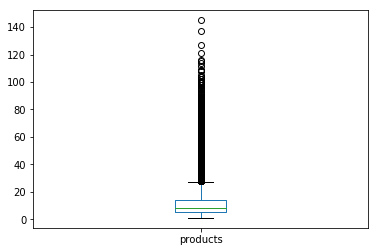

In [27]:
orders_and_product_counts["products"].plot(kind="box")

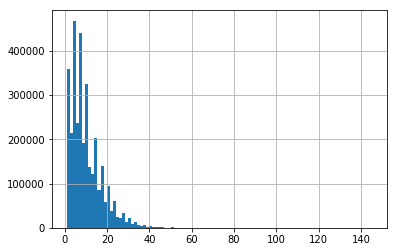

In [28]:
orders_and_product_counts["products"].hist(bins=100)

It looks like our amount of orders have Poisson distribution. Most of the orders do not have that many products. There are a lot of outliers that could interfere with further analysis. On average it is 10.1, but median, 8, seems like better measurement.

### How many different products each order has?

In [ ]:
cur.execute("SELECT a.oid, COUNT(a.pid) FROM (SELECT o.id AS oid, op.product_id AS pid FROM orders AS o JOIN order_products AS op ON op.order_id = o.id GROUP BY o.id, op.product_id) AS a GROUP BY a.oid")
orders_and_products = pd.DataFrame(cur.fetchall())
orders_and_products.columns = ["order id", "products"]
orders_and_products.head()

In [ ]:
orders_and_products["products"].describe()

In [ ]:
orders_and_products["products"].plot(kind="box")

In [ ]:
orders_and_products["products"].hist(bins=100)

Results doesn't differ very much from previous question. It may be the case that people are buying different products more than products in bulk.

### At what day and time users buy the most?

In [ ]:
cur.execute("SELECT day_of_week, hour_of_day, COUNT(id) FROM orders GROUP BY day_of_week, hour_of_day")
daytime = pd.DataFrame(cur.fetchall())
daytime.columns = ["day", "hour", "orders"]
daytime.head()

In [ ]:
days = pd.DataFrame(daytime.groupby("day")["orders"].sum())
days

In [ ]:
days.describe()

In [ ]:
days.plot(kind="bar")

On all days, about same amount of orders are made except for days 0 and 1. On these days, order amount increases. Since I couldn't find information what number what day means, but I think that 0 and 1 should be Saturday-Sunday.

In [ ]:
hours = pd.DataFrame(daytime.groupby("hour")["orders"].sum())
hours

In [ ]:
hours.describe()

In [ ]:
hours.plot(kind="bar")

Mid day is when orders come. This reminds Gaussian distribution.

### How well each department sells?

In [ ]:
cur.execute("SELECT d.name, COUNT(p.id) FROM departments AS d JOIN products AS p ON p.department_id = d.id JOIN order_products AS op ON p.id = op.product_id GROUP BY d.id")
department_sells = pd.DataFrame(cur.fetchall())
department_sells.columns = ["name", "products sold"]
department_sells.head()

In [ ]:
department_sells.describe()

In [ ]:
department_sells.plot(kind="bar", x="name")

It seems that our previous observation that shop sells mostly consumables has one more proof.

### How well each aisle sells?

In [ ]:
cur.execute("SELECT a.name, COUNT(p.id) FROM aisles AS a JOIN products AS p ON p.department_id = a.id JOIN order_products AS op ON p.id = op.product_id GROUP BY a.id")
aisle_sells = pd.DataFrame(cur.fetchall())
aisle_sells.columns = ["name", "products sold"]
aisle_sells.head()

In [ ]:
aisle_sells.describe()

In [ ]:
aisle_sells.plot(kind="bar", x="name")

Same here - it looks like mostly what we are selling is edible or drinkable.